In [4]:
import torch
import json
import gensim.downloader as api
import numpy as np
import pickle
# from google.colab import drive
import tensorflow as tf
# from tensorflow.keras.utils import tf_utils
from tensorflow import keras
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam
import keras.backend as K
import keras.layers as L
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow_addons.text import crf_log_likelihood, crf_decode
from sklearn.metrics import f1_score

# drive.mount('/content/drive')

In [5]:
with open('Json Task1/NER_train.json', 'r') as f:
    task1_train_data = json.load(f)

with open('Json Task1/NER_val.json', 'r') as f:
    task1_val_data = json.load(f)

with open('Json Task1/NER_test.json', 'r') as f:
    task1_test_data = json.load(f)

with open('Json Task2/ATE_train.json', 'r') as f:
    task2_train_data = json.load(f)

with open('Json Task2/ATE_val.json', 'r') as f:
    task2_val_data = json.load(f)

with open('Json Task2/ATE_test.json', 'r') as f:
    task2_test_data = json.load(f)

with open('glove_embedding.pkl', 'rb') as pickle_file:
    glove_embeddings = pickle.load(pickle_file)
    
with open('fast_text_embedding.pkl', 'rb') as pickle_file:
    fast_text_embedding = pickle.load(pickle_file)

with open('word2vec_embeddings.pkl', 'rb') as pickle_file:
    word2vec_embeddings = pickle.load(pickle_file)

bio_mapping_task1 = {'B_ORG': 0, 'I_ORG': 1, 'B_RESPONDENT': 2, 'I_RESPONDENT': 3, 'B_JUDGE': 4, 'I_JUDGE': 5,
               'B_STATUTE': 6, 'I_STATUTE': 7, 'B_OTHER_PERSON': 8, 'I_OTHER_PERSON': 9, 'B_COURT': 10, 'I_COURT': 11,
               'B_GPE': 12, 'I_GPE': 13, 'B_PETITIONER': 14, 'I_PETITIONER': 15, 'B_WITNESS': 16, 'I_WITNESS': 17,
               'B_CASE_NUMBER': 18, 'I_CASE_NUMBER': 19, 'B_PRECEDENT': 20, 'I_PRECEDENT': 21, 'B_DATE': 22, 'I_DATE': 23,
               'B_PROVISION': 24, 'I_PROVISION': 25, 'O': 26}
bio_mapping_task2 = {'O' : 0, 'I' : 1, 'B' : 2}

In [6]:
word_to_index_w2v = {}
ind = 0
word2vec_embeddings['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in word2vec_embeddings.keys():
  word_to_index_w2v[word] = ind
  ind = ind + 1

vocab_size_w2v = len(word_to_index_w2v)

In [7]:
word_to_index_glove = {}
ind = 0
glove_embeddings['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in glove_embeddings.keys():
  word_to_index_glove[word] = ind
  ind = ind + 1

vocab_size_glove = len(word_to_index_glove)

In [8]:
word_to_index_fasttext = {}
ind = 0
fast_text_embedding['<unk>'] = np.zeros((1, 300), dtype = 'float32')

for word in fast_text_embedding.keys():
  word_to_index_fasttext[word] = ind
  ind = ind + 1

vocab_size_fasttext = len(word_to_index_fasttext)

In [9]:
def process_data(dataset,task,split, embedding_type):
    sentences = []
    labels = []
    max_length_train_1 = 80
    max_length_train_2 = 83
    # max_length_test_1 = 52
    # max_length_test_2 = 71
    max_seq_len = 0

    if task == 1:
        bio_mapping = bio_mapping_task1
        max_seq_len = max_length_train_1
    else:
        bio_mapping = bio_mapping_task2
        max_seq_len = max_length_train_2

# choosing embedding type
    if embedding_type == "word2vec":
        word_to_index = word_to_index_w2v

    if embedding_type == "glove":
        word_to_index = word_to_index_glove

    else:
        word_to_index = word_to_index_fasttext

    for index in dataset.keys():

        dic = dataset[index]
        tags = [bio_mapping[label] for label in dic['labels']]
        sentence = dic['text'].split(' ')
        sequence = []
        for word in sentence:
            if word in word_to_index:
                sequence.append(word_to_index[word])
            else:
                sequence.append(word_to_index['<unk>'])
        if(len(sequence) >= max_seq_len):
            continue

        if(len(sequence) < max_seq_len):
            for i in range(len(sequence), max_seq_len):
                sequence.append(word_to_index['<unk>'])
                tags.append(bio_mapping['O'])
                # tags.append(3)

        sentences.append(sequence)
        labels.append(tags)

    tag_size = len(bio_mapping)
    labels = [to_categorical(i, num_classes = tag_size) for i in labels]

    return np.array(sentences), np.asarray(labels)

In [11]:
X_train, y_train = process_data(task1_train_data, 1, split = "train", embedding_type = "fast_text")
X_val, y_val = process_data(task1_val_data, 1, split = "val", embedding_type = "fast_text")
X_test, y_test = process_data(task1_test_data, 1, split = "test", embedding_type = "fast_text")
print(X_test, y_test)


[[ 1921    88 16547 ... 26967 26967 26967]
 [ 1444    64     2 ... 26967 26967 26967]
 [ 2494    89  2029 ... 26967 26967 26967]
 ...
 [25023  1800  1720 ... 26967 26967 26967]
 [  339   283  1970 ... 26967 26967 26967]
 [ 7552   397  4043 ... 26967 26967 26967]] [[[0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  ...
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]]

 [[0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 0. 

In [16]:
class CRF(L.Layer):
    def __init__(self, output_dim, **kwargs):
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim)
        self.transitions = None

    def build(self, input_shape):
        self.transitions = self.add_weight(name = 'transitions', shape=[self.output_dim, self.output_dim],
                                           initializer = 'glorot_uniform', trainable = True)

    def call(self, inputs, sequence_lengths = None, training = None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype = self.dtype)
        if sequence_lengths is not None:
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype = tf.int32) * tf.shape(inputs)[1]

        viterbi_sequence, _ = crf_decode(sequences, self.transitions, self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            log_likelihood, self.transitions = crf_log_likelihood(y_pred,
                                                                  tf.cast(K.argmax(y_true), dtype=tf.int32),
                                                                  self.sequence_lengths,
                                                                  transition_params=self.transitions)
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            mask = K.cast(K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * shape[1]
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

In [17]:
def build_1(vocab_size, word_index, emb_type):
    if emb_type == "word2vec":
        embeddings_index = word2vec_embeddings

    elif emb_type == "glove":
        embeddings_index = glove_embeddings
    else:
        embeddings_index = fast_text_embedding

    embeddings_index = {}
    embeddings_matrix = np.zeros((vocab_size, 300))

    for word, i in word_index.items():
        if i > vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = 300, input_length = 80, weights = [embeddings_matrix], mask_zero = True))
    model.add(Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.01)))
    model.add(Bidirectional(LSTM(units = 30, return_sequences = True, recurrent_dropout = 0.15)))
    model.add(TimeDistributed(Dense(27)))
    crf = CRF(27)
    model.add(crf)
    return model

In [18]:

def calculate_f1_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_argmax = np.argmax(y_pred, axis=-1)
    y_true_argmax = np.argmax(y_test, axis=-1)
    # print(X_test.shape, y_pred.shape, y_test.shape, y_pred_argmax.shape, y_true_argmax.shape)
    f1 = f1_score(y_true_argmax.flatten(), y_pred_argmax.flatten(), average='macro')
    return f1


In [34]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, X_test, y_test):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.train_losses = []
        self.val_losses = []
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # Training loss
        train_loss = logs['loss']
        self.train_losses.append(train_loss)

        # Training F1 score
        train_f1_score = calculate_f1_score(self.model, X_train, y_train)
        self.train_f1_scores.append(train_f1_score)

        # Validation loss
        t = self.model.evaluate(self.X_val, self.y_val, verbose=0)
        # print(t)
        val_loss = t[0]
        self.val_losses.append(val_loss)

        # Validation F1 score
        val_f1_score = calculate_f1_score(self.model, self.X_val, self.y_val)
        self.val_f1_scores.append(val_f1_score)

        # Print metrics
        print(f'Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Train F1 Score: {train_f1_score:.4f} - Val F1 Score: {val_f1_score:.4f}')

    def plot_results(self):
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_f1_scores, label='Training Macro F1-Score')
        plt.plot(epochs, self.val_f1_scores, label='Validation Macro F1-Score')
        plt.title('Training and Validation Macro F1-Scores')
        plt.xlabel('Epochs')
        plt.ylabel('Macro F1-Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [35]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU.")
else:
    print("TensorFlow is using CPU.")


TensorFlow is using CPU.


In [40]:
model = build_1(vocab_size = vocab_size_fasttext,  word_index = word_to_index_fasttext, emb_type = "fast_text")
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3), loss=model.layers[-1].loss, metrics=[model.layers[-1].accuracy])
metrics_callback = MetricsCallback(X_val, y_val, X_test, y_test)
history = model.fit(X_train, y_train, batch_size = 8, epochs = 6, validation_data = (X_val, y_val), verbose = 0, callbacks = [metrics_callback])



44/44 [==============================] - 3s 58ms/step
Epoch 1 - Train Loss: 19.4284 - Val Loss: 166.8310 - Train F1 Score: 0.1515 - Val F1 Score: 0.1460
44/44 [==============================] - 3s 62ms/step
Epoch 2 - Train Loss: 7.9722 - Val Loss: 151.1634 - Train F1 Score: 0.4741 - Val F1 Score: 0.4145
44/44 [==============================] - 3s 64ms/step
Epoch 3 - Train Loss: 4.0375 - Val Loss: 140.4659 - Train F1 Score: 0.6918 - Val F1 Score: 0.5322
44/44 [==============================] - 3s 62ms/step
Epoch 4 - Train Loss: 2.2301 - Val Loss: 131.9671 - Train F1 Score: 0.8541 - Val F1 Score: 0.5849
44/44 [==============================] - 3s 61ms/step
Epoch 5 - Train Loss: 1.3322 - Val Loss: 123.9553 - Train F1 Score: 0.9156 - Val F1 Score: 0.6169
44/44 [==============================] - 3s 59ms/step
Epoch 6 - Train Loss: 0.8627 - Val Loss: 115.4225 - Train F1 Score: 0.9568 - Val F1 Score: 0.6523


In [41]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose = 0)
test_f1_score = calculate_f1_score(model, X_test, y_test)
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f} - Test F1 Score: {test_f1_score:.4f}')

model.save('trained_models/t1_bilstm_crf_fast_text.h5')


29/29 [==============================] - 2s 59ms/step
Test Loss: 115.4915 - Test Accuracy: 0.9704 - Test F1 Score: 0.5676


/Users/nalishjain/Acad Sem 6/NLP-Assignments/A2_16/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


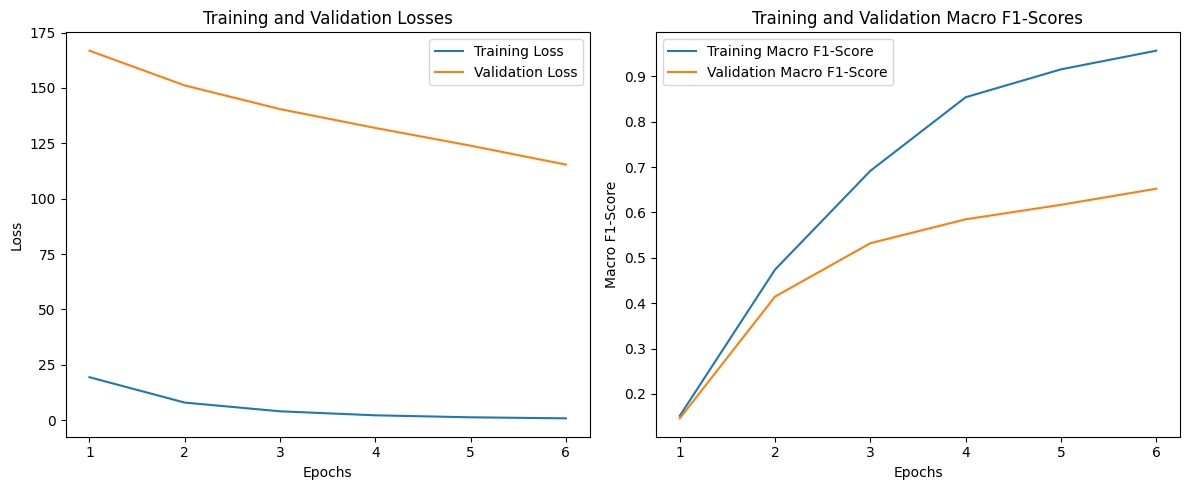

In [43]:
metrics_callback.plot_results()